In [2]:
# Import required libraries and set display configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-resolution plots in Jupyter
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Generate synthetic clustering dataset
X, y_true = make_blobs(
    n_samples=500,
    centers=4,
    n_features=5,
    random_state=42,
    cluster_std=1.5
)

# Create feature names
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nFeature statistics:")
print(df.describe())

Dataset shape: (500, 5)

First 5 rows:
   feature_0  feature_1  feature_2  feature_3  feature_4
0 -11.152924  -7.115179   4.713952   1.478639   2.481947
1  -9.768882   6.139193   7.919985  -6.556210  -6.499301
2  -8.209695   8.962785   7.049941  -5.270671  -7.365636
3  -6.929933  11.890086   5.963208  -6.656536  -5.660339
4  -3.768024   8.550468   5.136774   3.436487  -7.598389

Feature statistics:
        feature_0   feature_1   feature_2   feature_3   feature_4
count  500.000000  500.000000  500.000000  500.000000  500.000000
mean    -6.324389    1.451433    4.791389   -0.649059   -3.239502
std      2.965675    8.098991    3.081083    3.536746    4.744379
min    -13.970336  -12.474147   -3.411192  -10.061611  -10.418349
25%     -8.429486   -6.103168    2.528516   -3.626230   -6.641893
50%     -6.572339    2.471926    5.392993    0.037904   -5.013704
75%     -4.193016    9.141318    7.175928    2.068813    0.431622
max      0.603904   12.634159   11.193087    7.752267    8.110025


In [4]:
# Data preprocessing pipeline
def preprocess_data(df):
    """
    Preprocess the dataset: scale features (essential for K-Means)
    """
    # Scale the features (K-Means is sensitive to feature scales)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    return X_scaled, scaler

X_scaled, scaler = preprocess_data(df)

print("Scaled data shape:", X_scaled.shape)
print("Scaled data statistics:")
print(f"Mean: {X_scaled.mean(axis=0)[:3]}...")  # Show first 3 means
print(f"Std: {X_scaled.std(axis=0)[:3]}...")   # Show first 3 stds

Scaled data shape: (500, 5)
Scaled data statistics:
Mean: [-2.49078536e-15 -1.81188398e-16  7.41184891e-16]...
Std: [1. 1. 1.]...


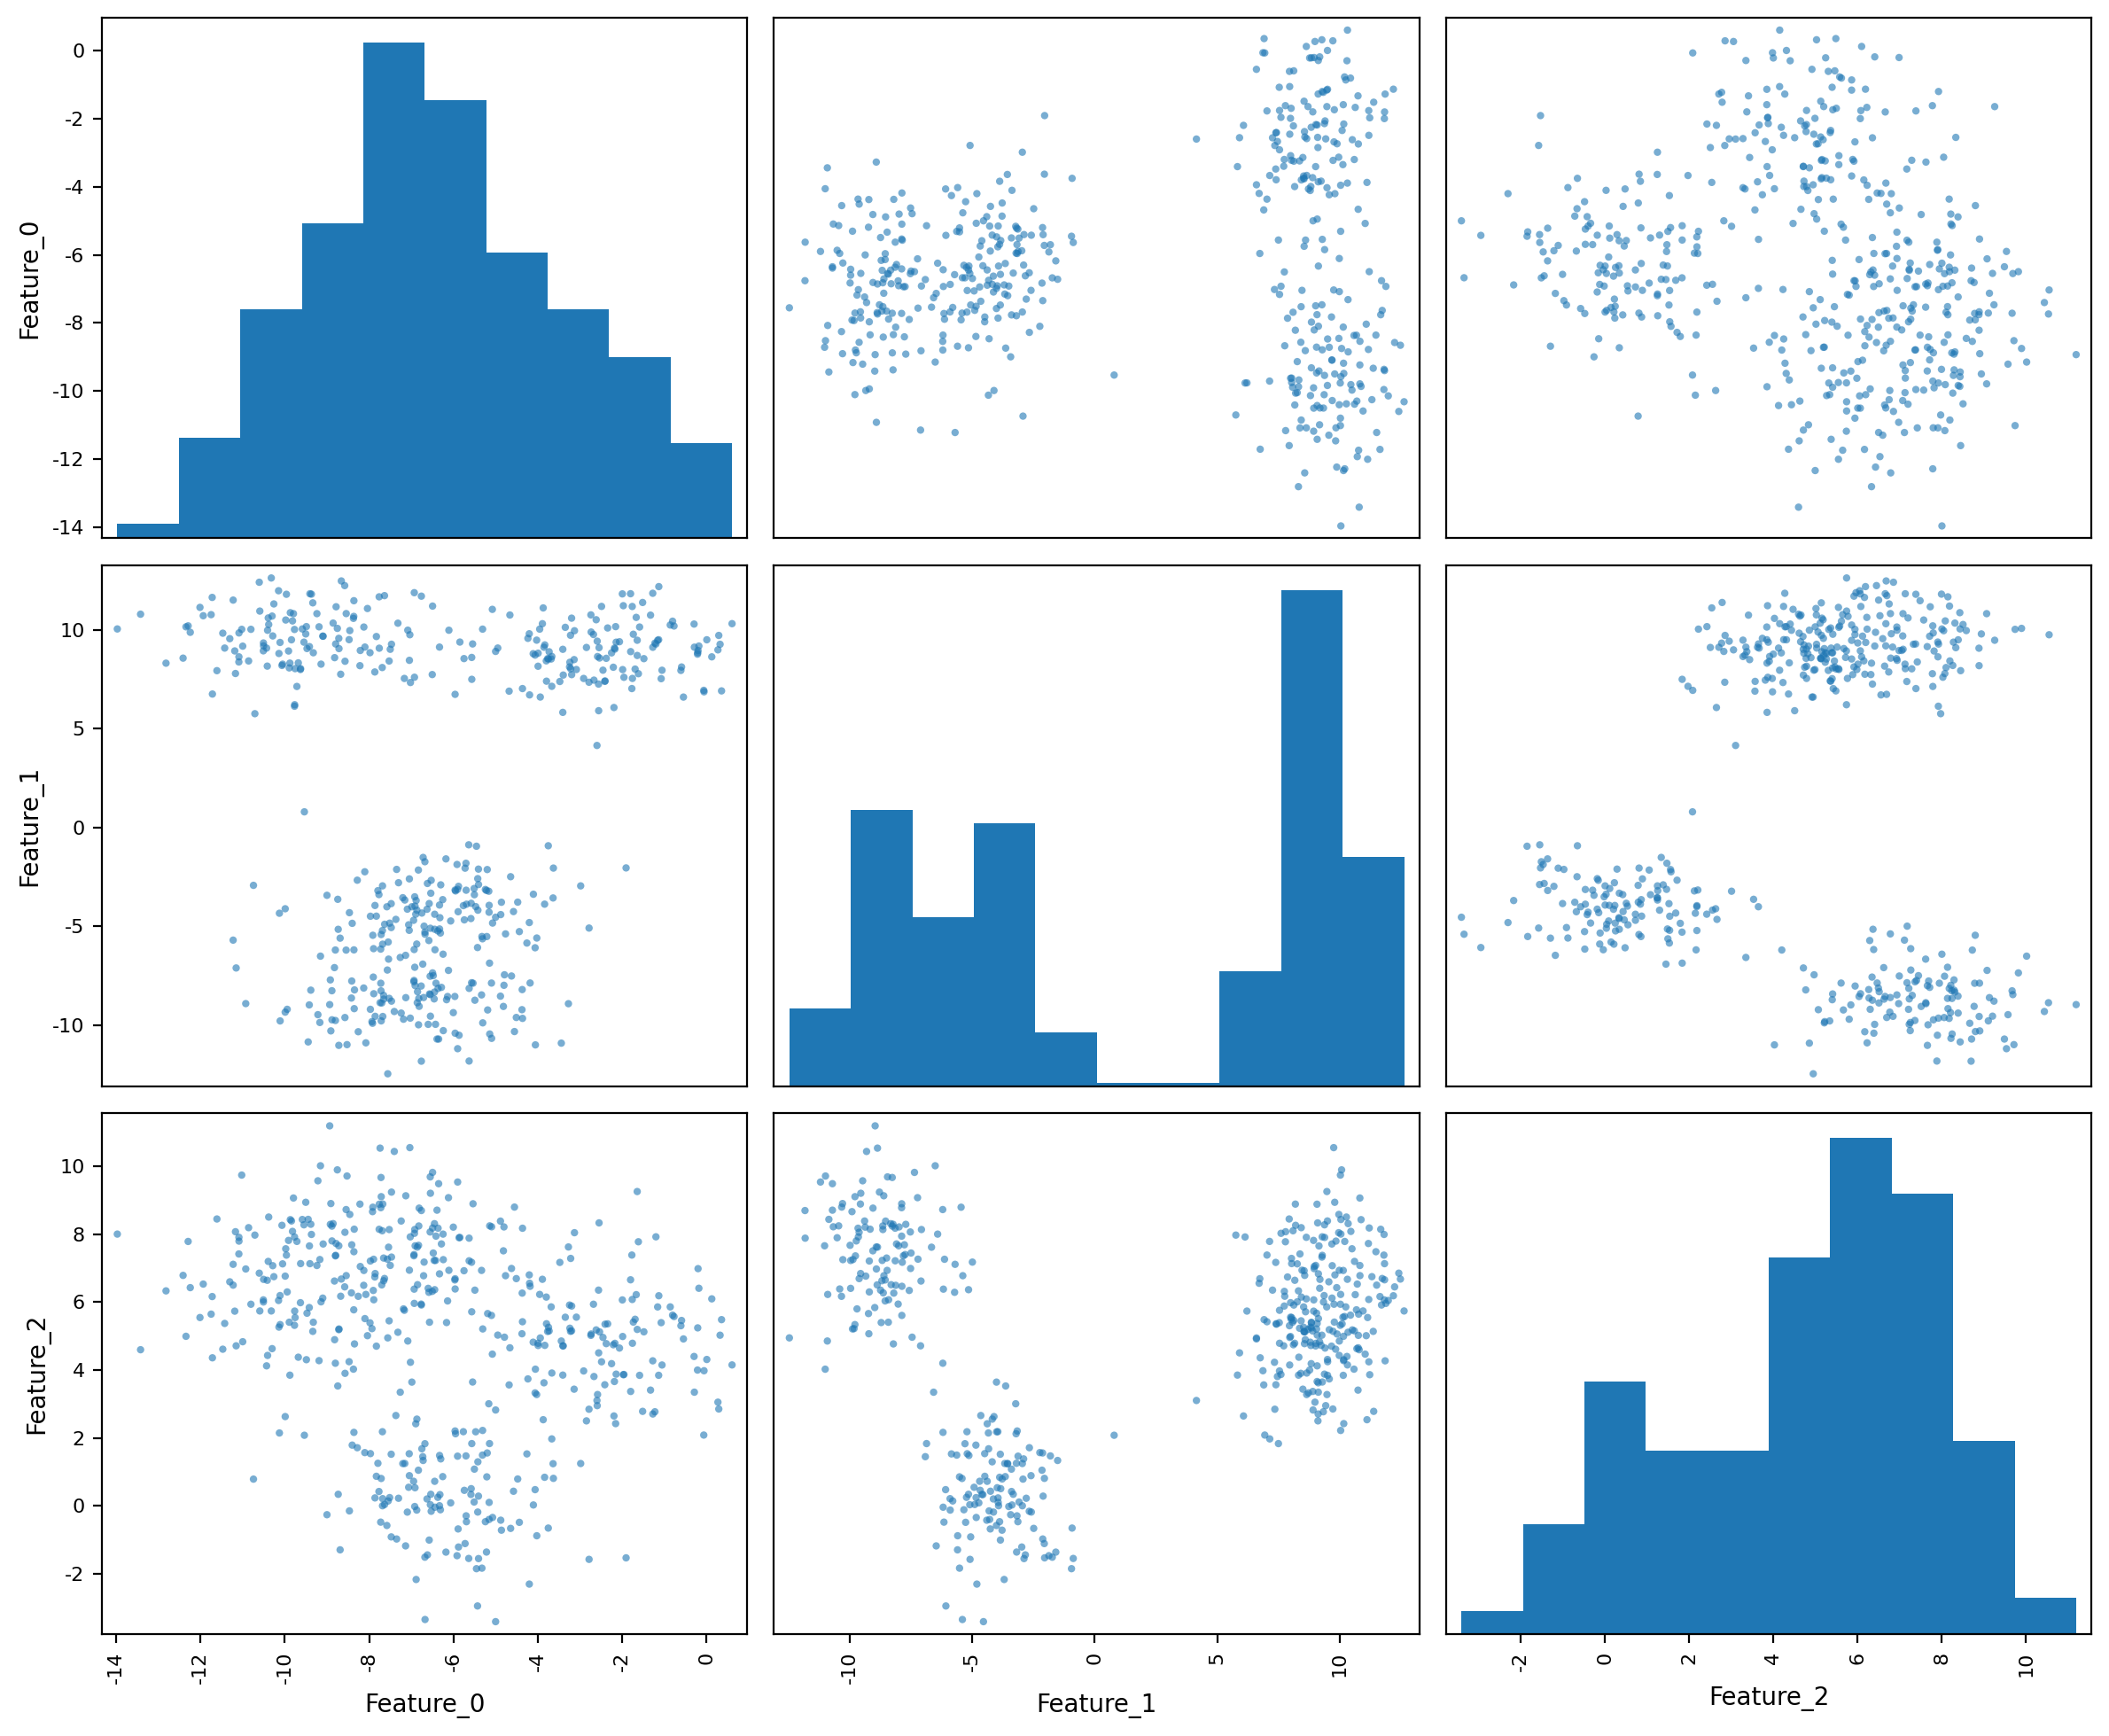

In [5]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2)

# Distribution of features
axes[0,0].hist(df.iloc[:, 0], bins=30, edgecolor='black', alpha=0.7)
axes[0,0].set_title(f'Distribution of {feature_names[0]}')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Frequency')

# Feature correlation heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[0,1])
axes[0,1].set_title('Feature Correlation Matrix')

# Scatter plot of first two features
axes[1,0].scatter(df.iloc[:, 0], df.iloc[:, 1], alpha=0.6)
axes[1,0].set_xlabel(feature_names[0])
axes[1,0].set_ylabel(feature_names[1])
axes[1,0].set_title(f'{feature_names[0]} vs {feature_names[1]}')

# Pair plot for first 3 features (sample)
df_sample = df.iloc[:, :3]
df_sample.columns = [f'Feature_{i}' for i in range(3)]
pd.plotting.scatter_matrix(df_sample, alpha=0.6, ax=axes[1,1])
axes[1,1].set_title('Pair Plot (First 3 Features)')

plt.tight_layout()
plt.show()

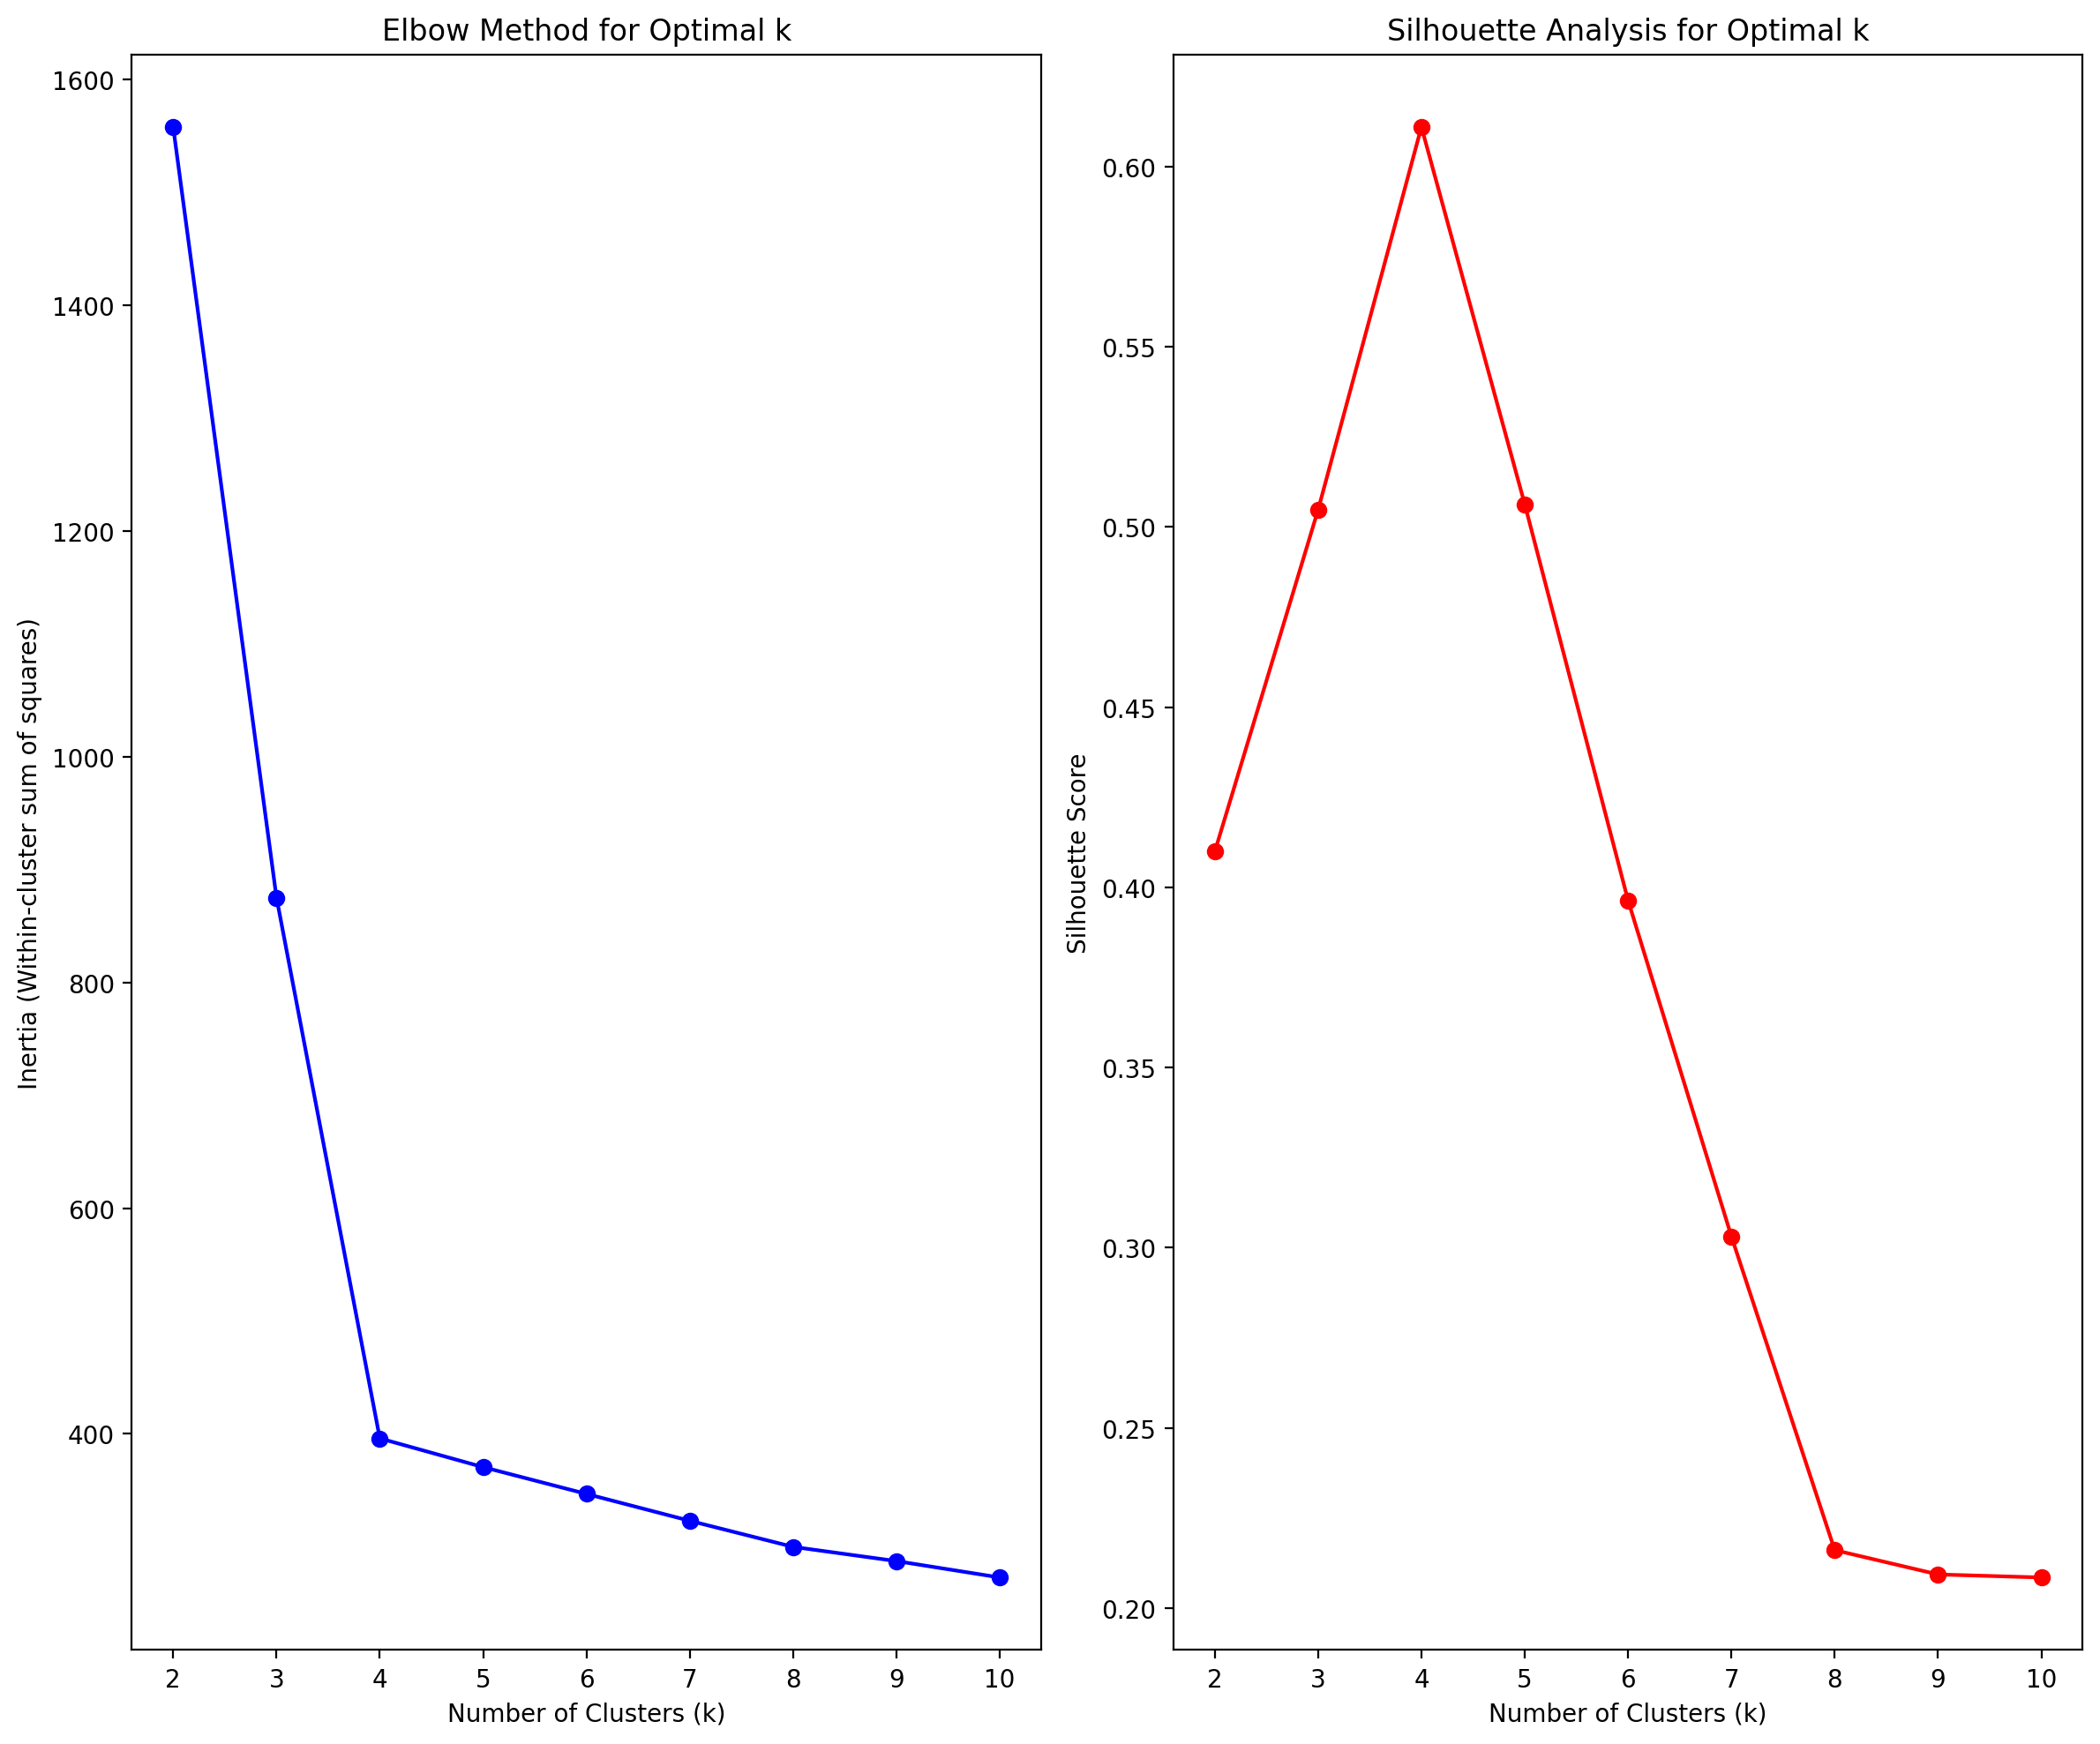

Optimal number of clusters based on silhouette score: 4
Silhouette score for k=4: 0.6110


In [6]:
# Determine optimal number of clusters using Elbow Method and Silhouette Analysis
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Plot Elbow curve and Silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal k')

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal k')

plt.tight_layout()
plt.show()

# Find the optimal number of clusters
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Silhouette score for k={optimal_k}: {max(silhouette_scores):.4f}")

In [7]:
# Train K-Means model with optimal number of clusters
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = optimal_kmeans.fit_predict(X_scaled)

# Calculate evaluation metrics
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)

print("K-Means Clustering Results:")
print(f"Number of clusters: {optimal_k}")
print(f"Cluster distribution: {np.bincount(cluster_labels)}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")

# Get cluster centers in original scale
cluster_centers_original = scaler.inverse_transform(optimal_kmeans.cluster_centers_)
print(f"\nCluster Centers (in original scale):")
for i, center in enumerate(cluster_centers_original):
    print(f"Cluster {i}: {center[:3]}...")  # Show first 3 dimensions

K-Means Clustering Results:
Number of clusters: 4
Cluster distribution: [125 125 125 125]
Silhouette Score: 0.6110
Calinski-Harabasz Score: 878.3487
Davies-Bouldin Score: 0.5645

Cluster Centers (in original scale):
Cluster 0: [-2.45873211  8.87052047  4.81110267]...
Cluster 1: [-6.3358863  -3.95207569  0.349741  ]...
Cluster 2: [-7.03525532 -8.70862778  7.40675794]...
Cluster 3: [-9.46768075  9.59591416  6.59795256]...


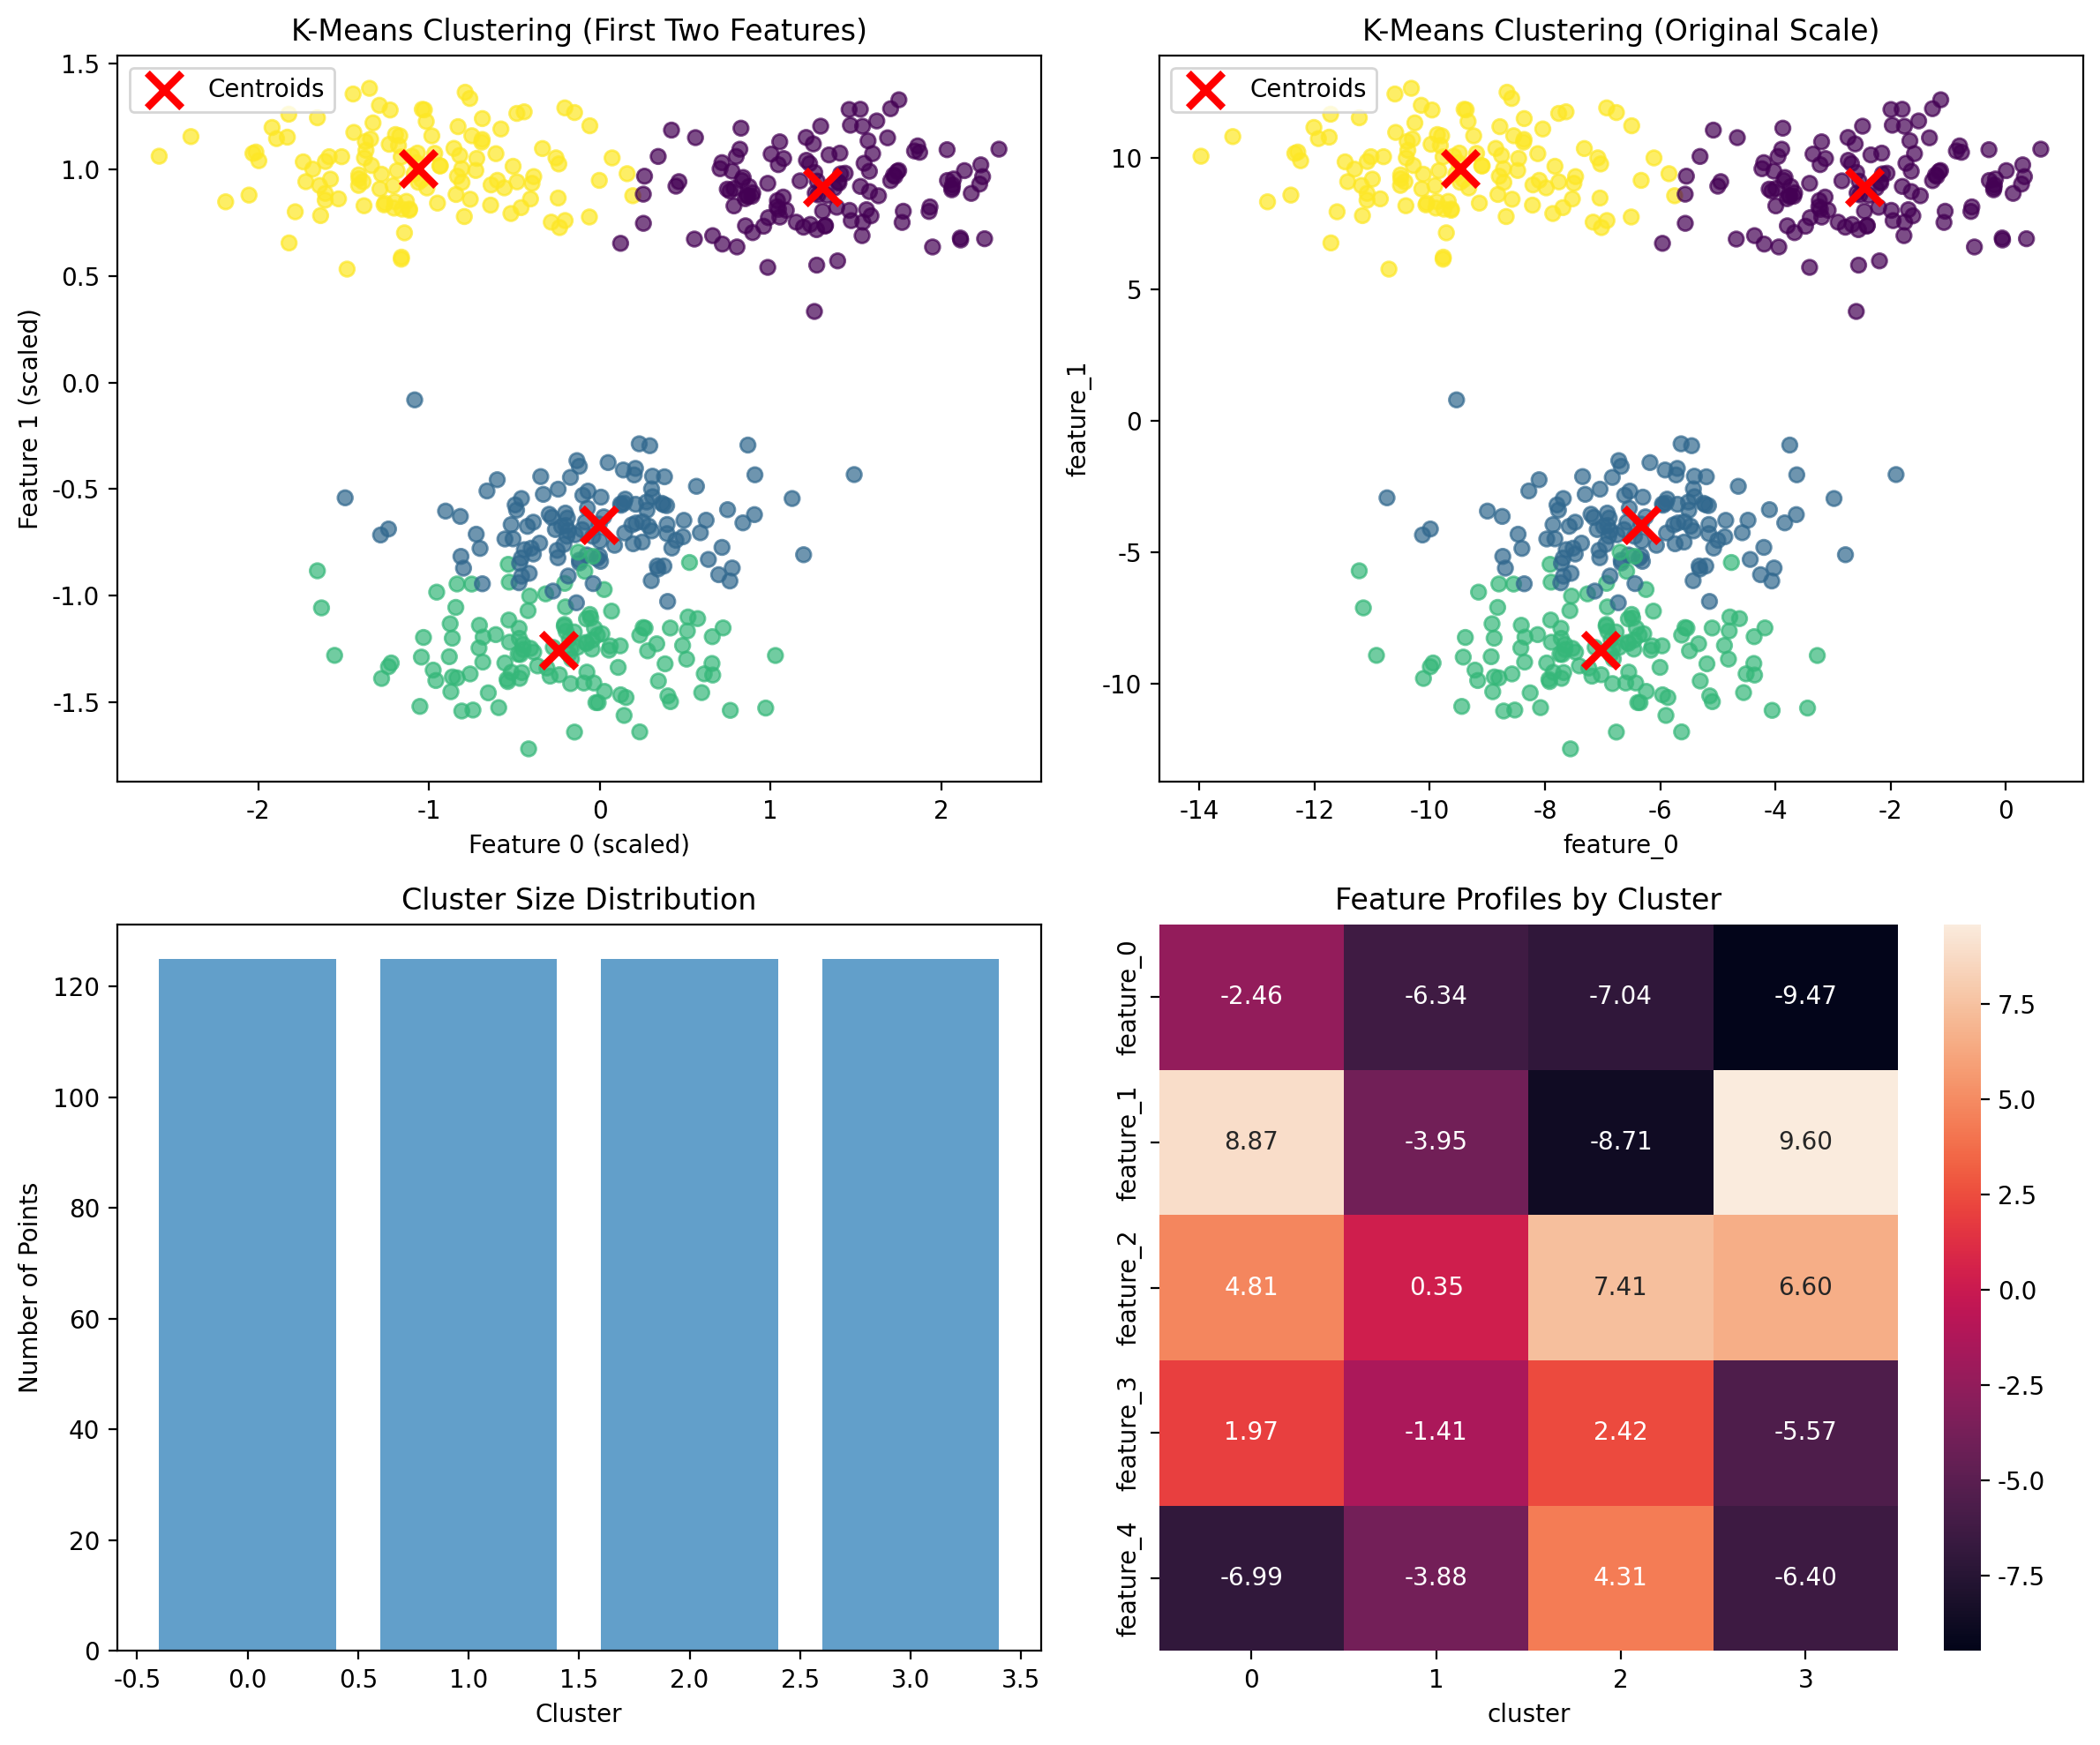

In [10]:
# Visualization of clustering results
fig, axes = plt.subplots(2, 2)

# Cluster visualization using first two features
scatter = axes[0,0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
axes[0,0].scatter(optimal_kmeans.cluster_centers_[:, 0], optimal_kmeans.cluster_centers_[:, 1],
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[0,0].set_xlabel('Feature 0 (scaled)')
axes[0,0].set_ylabel('Feature 1 (scaled)')
axes[0,0].set_title('K-Means Clustering (First Two Features)')
axes[0,0].legend()

# Cluster visualization using first two original features
df_with_clusters = df.copy()
df_with_clusters['cluster'] = cluster_labels
scatter = axes[0,1].scatter(df.iloc[:, 0], df.iloc[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
axes[0,1].scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 1],
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[0,1].set_xlabel(feature_names[0])
axes[0,1].set_ylabel(feature_names[1])
axes[0,1].set_title('K-Means Clustering (Original Scale)')
axes[0,1].legend()

# Cluster distribution
cluster_counts = np.bincount(cluster_labels)
axes[1,0].bar(range(len(cluster_counts)), cluster_counts, alpha=0.7)
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Number of Points')
axes[1,0].set_title('Cluster Size Distribution')

# Feature profiles for each cluster
cluster_profiles = df_with_clusters.groupby('cluster').mean()
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', ax=axes[1,1])
axes[1,1].set_title('Feature Profiles by Cluster')

plt.tight_layout()
plt.show()

In [9]:
# Model interpretation and insights
print("Cluster Analysis:")
cluster_analysis = df_with_clusters.groupby('cluster').agg(['mean', 'std']).round(3)
print(cluster_analysis)

print(f"\nK-Means Model Parameters:")
print(f"Inertia (within-cluster sum of squares): {optimal_kmeans.inertia_:.4f}")
print(f"Number of iterations: {optimal_kmeans.n_iter_}")

# Calculate distance of each point to its cluster center
distances_to_centers = np.sqrt(((X_scaled - optimal_kmeans.cluster_centers_[cluster_labels]) ** 2).sum(axis=1))
print(f"\nAverage distance to cluster centers: {distances_to_centers.mean():.4f}")
print(f"Standard deviation of distances: {distances_to_centers.std():.4f}")

# Identify cluster characteristics
for i in range(optimal_k):
    cluster_data = df_with_clusters[df_with_clusters['cluster'] == i]
    print(f"\nCluster {i} characteristics:")
    print(f"  Size: {len(cluster_data)} points ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"  Mean values: {cluster_data[feature_names].mean().round(2).to_dict()}")

Cluster Analysis:
        feature_0        feature_1        feature_2        feature_3         \
             mean    std      mean    std      mean    std      mean    std   
cluster                                                                       
0          -2.459  1.499     8.871  1.425     4.811  1.436     1.965  1.606   
1          -6.336  1.510    -3.952  1.379     0.350  1.364    -1.409  1.532   
2          -7.035  1.609    -8.709  1.478     7.407  1.461     2.421  1.448   
3          -9.468  1.656     9.596  1.413     6.598  1.440    -5.574  1.375   

        feature_4         
             mean    std  
cluster                   
0          -6.988  1.383  
1          -3.879  1.489  
2           4.313  1.440  
3          -6.404  1.486  

K-Means Model Parameters:
Inertia (within-cluster sum of squares): 396.0338
Number of iterations: 2

Average distance to cluster centers: 0.8348
Standard deviation of distances: 0.3085

Cluster 0 characteristics:
  Size: 125 points (25.0%